# Acoustic signal cutting and padding

- cut and pad signal to unify the dataset of each wav file 
- Each file will be segmented into 1 second pieces
- the labels and relevent informations will be recorded in the metadata file stored in csv file

In [1]:
## Required python libraries
import pandas as pd
import numpy as np
import scipy as sp
import os
import math
import sys

# to make this notebook's output stable across runs
np.random.seed(42)

pd.plotting.register_matplotlib_converters()


import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

In [2]:
## Audio signal processing libraries
import librosa
import librosa.display
import IPython.display as ipd

In [3]:
import scaleogram as scg 
from glob import glob
import glob
import re
import scipy
from scipy.signal import welch
import wave                    # library handles the parsing of WAV file headers
import pywt
import soundfile as sf

In [4]:
# Pytorch libraryes and torchaudio - for GPU accelerated feature extraction
import torch
import torchaudio
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchsummary import summary

In [5]:
# Where to save the figures, and dataset locations
PROJECT_ROOT_DIR = "../"
Audio_PATH_original = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', "original", 'train')
Audio_PATH_equalized = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', "equalized")
Audio_PATH_bandpassed = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', "bandpassed")
Audio_PATH_denoised = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', "denoised", 'train')

Audio_PATH_original_slice = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', "original", "sliced_layers")
Audio_PATH_equalized_slice = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', "equalized", "sliced_layers")
Audio_PATH_bandpass_slice = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', "bandpassed", "sliced_layers")
Audio_PATH_denoised_slice = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', "denoised", "sliced_layers")

Audio_PATH_original_segmented = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', "segment", "original") 
Audio_PATH_equalized_segmented = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', "segment", "equalized")  
Audio_PATH_bandpassed_segmented = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', "segment", "bandpassed")
Audio_PATH_denoised_segmented = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment', 'wave_file', "segment", "denoised")



Experiment_PATH = os.path.join(PROJECT_ROOT_DIR, "AM_audio_dataset", 'AMDataset_v4_June_Experiment')
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'AMDataset_v4_June_Experiment','EDA_analysis')
os.makedirs(Audio_PATH_original, exist_ok=True)
os.makedirs(Audio_PATH_original_slice, exist_ok=True)
os.makedirs(Audio_PATH_equalized_slice, exist_ok=True)
os.makedirs(Audio_PATH_bandpass_slice, exist_ok=True)
os.makedirs(Audio_PATH_denoised_slice, exist_ok=True)
os.makedirs(IMAGE_PATH, exist_ok=True)

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [6]:
sys.path.insert(0, '../utils')

import utils
import filter
import feature_extractions

## Step 1: Load data

##  Read all the files with pandas datafram

In [7]:
# AM_wav_original = glob(Audio_PATH_deep_learning_original_train + '\\*.wav')
files = glob.glob1(Audio_PATH_original_slice, '*.wav') #Audio_PATH_original, Audio_PATH_deep_learning_original_train
# Sort files according to the digits included in the filename
files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[0]))
files[0] = Audio_PATH_original_slice + "\\" + files[0] 

In [22]:
files = glob.glob1(Audio_PATH_original_slice, '*.wav')
# Sort files according to the digits included in the filename
files = sorted(files, key=lambda x:float(re.findall("(\d+)",x)[0]))
for i in range(len(files)):
    files[i]= Audio_PATH_original_slice + "\\" + files[i]

for file in files:
    filename = os.path.basename(file) # exp_22_raw_layer_1
    layer_number = os.path.basename(file).split("_")[4].split(".")[0]
    experiment_number = os.path.basename(file).split("_")[1]
    # print (layer_number)
    dur = librosa.get_duration(filename = file)
    audio_signal = librosa.load(file, sr=None)[0]
    print (audio_signal.shape[0]/44100)


3.995986394557823
3.9960090702947846
3.995986394557823
3.9960090702947846
3.995986394557823
3.9960090702947846
3.9960090702947846
3.995986394557823
3.9960090702947846
3.995986394557823
3.9960090702947846
3.9960090702947846
3.9960090702947846
3.995986394557823
3.9960090702947846
3.995986394557823
3.9960090702947846
3.9960090702947846
3.995986394557823
3.9960090702947846
3.995986394557823
3.9960090702947846
3.995986394557823
3.9960090702947846
3.995986394557823
3.9960090702947846
3.995986394557823
3.9960090702947846
3.9960090702947846
3.995986394557823
3.9960090702947846
3.995986394557823
3.9960090702947846
3.9960090702947846
3.9960090702947846
3.995986394557823
3.9960090702947846
3.995986394557823
3.9960090702947846
3.9960090702947846
3.995986394557823
3.9960090702947846
3.995986394557823
3.9960090702947846
3.9960090702947846
3.9960090702947846
3.995986394557823
3.9960090702947846
3.995986394557823
3.9960090702947846
3.7
3.7
3.7
3.7
3.7
3.7
3.7
3.7
3.7
3.7
3.7
3.7
3.7
3.7
3.7
3.7
3.7
3.

In [15]:
files

['../AM_audio_dataset\\AMDataset_v4_June_Experiment\\wave_file\\original\\sliced_layers\\exp_21_raw_layer_1.wav',
 '../AM_audio_dataset\\AMDataset_v4_June_Experiment\\wave_file\\original\\sliced_layers\\exp_21_raw_layer_10.wav',
 '../AM_audio_dataset\\AMDataset_v4_June_Experiment\\wave_file\\original\\sliced_layers\\exp_21_raw_layer_11.wav',
 '../AM_audio_dataset\\AMDataset_v4_June_Experiment\\wave_file\\original\\sliced_layers\\exp_21_raw_layer_12.wav',
 '../AM_audio_dataset\\AMDataset_v4_June_Experiment\\wave_file\\original\\sliced_layers\\exp_21_raw_layer_13.wav',
 '../AM_audio_dataset\\AMDataset_v4_June_Experiment\\wave_file\\original\\sliced_layers\\exp_21_raw_layer_14.wav',
 '../AM_audio_dataset\\AMDataset_v4_June_Experiment\\wave_file\\original\\sliced_layers\\exp_21_raw_layer_15.wav',
 '../AM_audio_dataset\\AMDataset_v4_June_Experiment\\wave_file\\original\\sliced_layers\\exp_21_raw_layer_16.wav',
 '../AM_audio_dataset\\AMDataset_v4_June_Experiment\\wave_file\\original\\sliced_

## Automatically extracting and segmenting the audio files into small chuncks - 1 second length

In [9]:
Audio_PATH_original_slice

'../AM_audio_dataset\\AMDataset_v4_June_Experiment\\wave_file\\original\\sliced_layers'

In [10]:
def generate_signal_dataframe(audio_file_path, dataset_list):
    AM_wav_files = glob.glob1(audio_file_path, '*.wav')
    AM_wav_files_sorted = sorted(AM_wav_files, key=lambda x:float(re.findall("(\d+)",x)[0]))
    for i in range(len(AM_wav_files_sorted)):
        AM_wav_files_sorted[i]= audio_file_path + "\\" + AM_wav_files_sorted[i]
    print(f'Total wav file in the folder :{len(AM_wav_files_sorted)}')
    
    for file in AM_wav_files_sorted:
        # ../AM_audio_dataset\\AMDataset_v4_June_Experiment\\wave_file\\original\\sliced_layers\\exp_22_raw_layer_1.wav'

        filename = os.path.basename(file) # exp_22_raw_layer_1
        experiment_number = os.path.basename(file).split("_")[1]
        layer_number = os.path.basename(file).split("_")[4].split(".")[0]
        category =  os.path.basename(file).split("_")[2]
        filepath = file
        dur = librosa.get_duration(filename = file)
        # compile label wav
        dataset_list.append({'filename': filename,
                             'experiment_number': experiment_number,
                             'layer_number': layer_number,
                             'category': category,
                             'wav_duration' : dur,
                             'file_path' : filepath })
        
    df_dataset_layer = pd.DataFrame(dataset_list)
    print(f'df_dataset_layer : {df_dataset_layer.shape}')
    
    return df_dataset_layer
    

In [11]:
dataset_original = []
dataset_equalized = []
dataset_bandpassed = []
dataset_denoised = []


df_original_layer = generate_signal_dataframe(Audio_PATH_original_slice, dataset_original)
df_equalized_layer = generate_signal_dataframe(Audio_PATH_equalized_slice, dataset_equalized)
df_bandpassed_layer = generate_signal_dataframe(Audio_PATH_bandpass_slice, dataset_bandpassed)
df_denoised_layer = generate_signal_dataframe(Audio_PATH_denoised_slice, dataset_denoised)

Total wav file in the folder :310
df_dataset_layer : (310, 6)
Total wav file in the folder :310
df_dataset_layer : (310, 6)
Total wav file in the folder :310
df_dataset_layer : (310, 6)
Total wav file in the folder :310
df_dataset_layer : (310, 6)


In [21]:
df_denoised_layer.head()

,filename,experiment_number,layer_number,category,wav_duration,file_path
0,exp_21_denoised_layer_1.wav,21,1,denoised,3.995986,../AM_audio_dataset\AMDataset_v4_June_Experime...
1,exp_21_denoised_layer_10.wav,21,10,denoised,3.996009,../AM_audio_dataset\AMDataset_v4_June_Experime...
2,exp_21_denoised_layer_11.wav,21,11,denoised,3.995986,../AM_audio_dataset\AMDataset_v4_June_Experime...
3,exp_21_denoised_layer_12.wav,21,12,denoised,3.996009,../AM_audio_dataset\AMDataset_v4_June_Experime...
4,exp_21_denoised_layer_13.wav,21,13,denoised,3.995986,../AM_audio_dataset\AMDataset_v4_June_Experime...


In [51]:
signal_example = librosa.load(df_denoised_layer["file_path"][80], sr=44100)[0]
dur = librosa.get_duration(signal_example, sr=44100)
dur

3.7

In [52]:
signal_example.shape[0]

163170

In [53]:
signal_pad = right_pad_if_necessary(signal_example, 4, 44100)
dur = librosa.get_duration(signal_pad, sr=44100)
dur

4.0

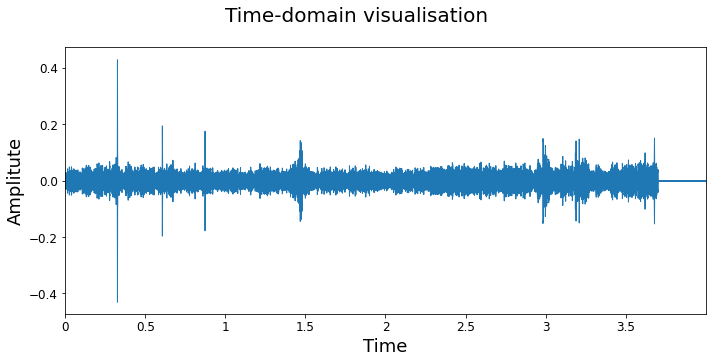

In [54]:
utils.simple_visualization(signal_pad)

In [58]:
from pydub import AudioSegment
import math
                            
        
def single_split(audio, from_sec, to_sec, sr=44100):
    t1 = int(from_sec * sr)
    t2 = int(to_sec * sr)
    split_audio = audio[t1:t2]
    # right_pad_if_necessary(split_audio, 1, 44100)
    return split_audio
        
def split_audio_multiple_v1(audio_signal, dur_per_split, folder, experiment_num):
    total_dur = int(librosa.get_duration(audio_signal, sr=44100))
    for index, i in enumerate(range(0, total_dur, dur_per_split)):
        split_audio = single_split(audio_signal, i, i+dur_per_split, sr=44100)
        sf.write(os.path.join(folder,  f'experiment_{experiment_num}_slice_{index}.wav'), split_audio, samplerate=44100) 
        # print(str(index) + ' Done')
        if i == total_dur - dur_per_split:
            print('All splited successfully')
            
def right_pad_if_necessary(signal, signal_dur, sampling_rate):
    length_signal = signal.shape[0] # int terms of (seconds * sr)
    if (length_signal > int(0.2*sampling_rate)) and (length_signal < int(signal_dur*sampling_rate)): # only do if larger than 0.4 s
        num_missing_samples = signal_dur*sampling_rate - length_signal
        last_dim_padding = (0, num_missing_samples) #(left side, right side)
        signal = np.pad(signal, last_dim_padding, mode='constant', constant_values=(0))
        signal = signal[:sampling_rate*signal_dur]
    else: 
        signal = signal[:sampling_rate*signal_dur]

    return signal
    
    
            
def split_audio_multiple(df_signal_layer, dur_per_split, folder):
    '''
    This function splits the audio file into multiple chuncks and save them into the specific path
    '''
    for index in df_signal_layer.index:
        # iterate each row (each files, layer-wise signals)
        audio_signal = librosa.load(df_signal_layer["file_path"][index], sr=None)[0]
        experiment_num = df_signal_layer["experiment_number"][index]
        layer_num = df_signal_layer["layer_number"][index]
        category = df_signal_layer["category"][index]
        
        total_dur = round(librosa.get_duration(audio_signal, sr=44100)) #e.g., 3.9 --> 4, 3.2 --> 3
        total_dur_str = librosa.get_duration(audio_signal, sr=44100)
        for ind, i in enumerate(range(0, total_dur, dur_per_split)):
            if i == total_dur - dur_per_split: # if i is the last one
                # e.g., 4 - 1 = 3 
                split_audio = single_split(audio_signal, i, total_dur_str, sr=44100)
                split_audio = right_pad_if_necessary(split_audio, 1, 44100)
                sf.write(os.path.join(folder,  'experiment_' + str(experiment_num) + "_layer_" 
                                      + str(layer_num) + "_slice_" + str(ind) + "_" + str(category) + ".wav"), split_audio, samplerate=44100) 
                print('All splited successfully ' + str(i))
            else: 
                split_audio = single_split(audio_signal, i, i+dur_per_split, sr=44100)
                sf.write(os.path.join(folder,  'experiment_' + str(experiment_num) + "_layer_" 
                                      + str(layer_num) + "_slice_" + str(ind) + "_" + str(category) + ".wav"), split_audio, samplerate=44100) 

            

In [56]:
round(3.2)
# for ind, i in enumerate(range(0, 3.9, 1)):
#     print (i)

3

In [59]:
split_audio_multiple(df_original_layer, 1, Audio_PATH_original_segmented)

All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
A

In [60]:
split_audio_multiple(df_equalized_layer, 1, Audio_PATH_equalized_segmented)
split_audio_multiple(df_bandpassed_layer, 1, Audio_PATH_bandpassed_segmented)
split_audio_multiple(df_denoised_layer, 1, Audio_PATH_denoised_segmented)

All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
All splited successfully 3
A